In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,StackingClassifier
import joblib
import os
%matplotlib inline

In [2]:
mnist_train = pd.read_csv('./fashion-mnist_train.csv')
mnist_test = pd.read_csv('./fashion-mnist_test.csv')


In [3]:
mnist_train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

### Labels
Each training and test example is assigned to one of the following labels:


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [4]:
X_train, y_train, X_test, y_test = mnist_train.iloc[:,1:], mnist_train['label'], mnist_test.iloc[:,1:], mnist_test['label']
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train.shape

(60000, 784)

In [6]:
y_train.shape

(60000,)

In [7]:
modelDir = './models'

if not os.path.exists(modelDir):
    os.makedirs(modelDir)
    
def save_model (model, file_name):
    if model:
        model_file_name = f"{file_name}_fmnist.sav"
        joblib.dump(model, os.path.join(modelDir,model_file_name))

def load_model (file_name):
    model_file_name = f"{file_name}_fmnist.sav"
    try:
        return joblib.load(os.path.join(modelDir,model_file_name))
    except:
        return None

In [8]:
def plot_samples(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


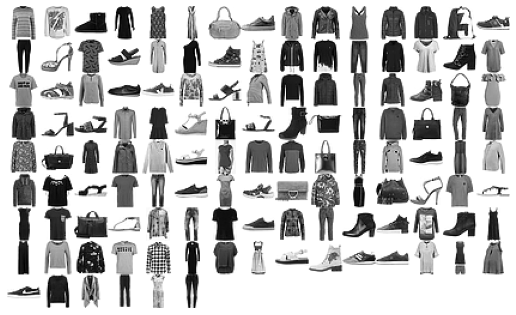

In [9]:
plt.figure(figsize=(9,9))
example_images = X_train[14:140]
plot_samples(example_images.values, images_per_row=15)
plt.show()

In [10]:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split( X_train, y_train, test_size=0.1, random_state=21)

In [11]:
print(x_train_data.shape)

print(y_train_data.shape)

(54000, 784)
(54000,)


In [12]:

pca = PCA(n_components=0.9, random_state=0,svd_solver='full')

x_train_data_pca = pca.fit_transform(x_train_data)
x_test_data_pca = pca.transform(x_test_data)
original_X_test_pca = pca.transform(X_test)


pca.n_components_


84

84


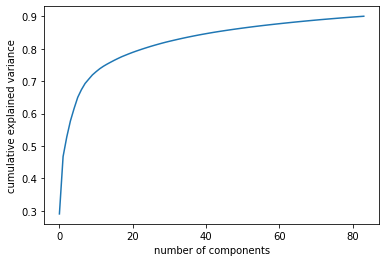

In [13]:

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(pca.n_components_)

## pre processing

In [14]:

scaling_pipeline = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('pca',PCA(n_components=0.90, random_state=0,svd_solver='full')),       
    ]
)

x_train_scaled = scaling_pipeline.fit_transform(x_train_data)
x_test_scaled = scaling_pipeline.transform(x_test_data)
original_X_test_scaled = scaling_pipeline.transform(X_test)


## KNN

In [15]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_scaled,y_train_data)
knn_clf.score(x_test_scaled,y_test_data)


0.8651666666666666

### Tunning KNN

In [16]:
tuned_knn = load_model("tuned_knn")
knn_grid = load_model("knn_grid")

if not tuned_knn:
    

    knn_param_grid =     {
         'n_neighbors': list(range(3,100,10)),
         'weights':['uniform','distance'],
         'metric': ['euclidean','manhattan','minkowski'],
        }

    knn_grid_search = RandomizedSearchCV(
        KNeighborsClassifier(n_jobs=-1),
        knn_param_grid,
        cv=3,
        scoring='accuracy',
        return_train_score=True,
        random_state=0
    )
    knn_grid_search.fit(x_train_scaled,y_train_data)
    save_model(knn_grid_search.best_estimator_,"tuned_knn")
    save_model(knn_grid_search, "knn_grid")
else:
    print("pretrained model loaded")
    tuned_knn
    

pretrained model loaded


In [17]:
knn_grid.best_estimator_

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=13)

In [18]:
knn_grid.best_score_

0.8577777777777778

## Random Forest 

In [19]:
forest_clf = RandomForestClassifier(random_state=0,n_estimators=200, n_jobs=-1)


forest_clf.fit(x_train_scaled,y_train_data)
forest_clf.score(x_test_scaled,y_test_data)


0.8676666666666667

### Tunning randomForest

In [20]:
tuned_forest = load_model("tuned_forest")
forest_grid = load_model("forest_grid")

if not tuned_forest:

    forest_params = {
         'n_estimators': [100,200,400],
         'max_depth':[None,30,100],
         'max_features': ['auto','sqrt','log2'],
         'random_state':[0]
    }


    forest_grid_search = RandomizedSearchCV(
        RandomForestClassifier(n_jobs=-1),
        forest_params,
        cv=3,
        scoring='accuracy',
        return_train_score=True,
        random_state=0
    )

    forest_grid_search.fit(x_train_scaled,y_train_data)
    save_model(forest_grid_search.best_estimator_, "tuned_forest")
    save_model(forest_grid_search, "forest_grid")
else:
    print("loaded pre trained model")


loaded pre trained model


In [21]:
forest_grid.best_estimator_

RandomForestClassifier(max_depth=30, max_features='sqrt', n_estimators=400,
                       n_jobs=-1, random_state=0)

In [22]:
forest_grid.best_score_

0.8672777777777778

## XGBoost

In [23]:
xgb_clf = XGBClassifier(n_jobs=-1, max_depth=6,gamma = 0,colsample_bytree = 0.8)

xgb_clf.fit(x_train_scaled,y_train_data)
xgb_clf.score(x_test_scaled,y_test_data)

0.8786666666666667

### Tunning XGBoost

In [24]:
tuned_xgb = load_model("tuned_xgb")
xgb_grid = load_model("xgb_grid")


if not tuned_xgb:

    xgb_params = {
        'max_depth': [3,6,10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000],
        'colsample_bytree': [0.3, 0.7]
    }

    xgb_clf = XGBClassifier(
        objective='multi:softmax',
        gamma = 0,
        colsample_bytree = 0.8)

    XGBGridsearch = RandomizedSearchCV(xgb_clf, xgb_params,scoring='accuracy',cv=3, random_state=0,n_jobs=-1)
    XGBGridsearch.fit(x_train_scaled,y_train_data)
    save_model(XGBGridsearch.best_estimator_,"tuned_xgb")
    save_model(XGBGridsearch, "xgb_grid")
else:
    print("loaded pre trained model")

loaded pre trained model


In [25]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
xgb_grid.best_score_

0.8861296296296297

In [27]:
print(tuned_xgb.score(original_X_test_scaled,y_test))

print(classification_report(tuned_xgb.predict(original_X_test_scaled),y_test))

0.8937
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1045
           1       0.97      0.99      0.98       983
           2       0.83      0.84      0.83       988
           3       0.93      0.90      0.91      1036
           4       0.86      0.83      0.85      1038
           5       0.94      0.96      0.95       975
           6       0.67      0.76      0.72       882
           7       0.94      0.92      0.93      1016
           8       0.98      0.96      0.97      1023
           9       0.95      0.94      0.94      1014

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



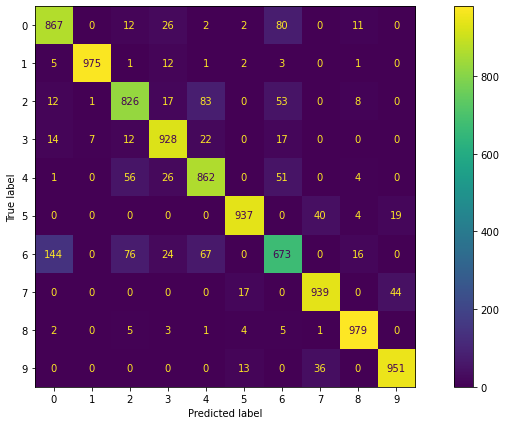

In [28]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(14,7)
plot_confusion_matrix(tuned_xgb,original_X_test_scaled,y_test,ax=ax)

## Stacking

In [29]:
stacking_clf = load_model('stacking_clf')

if not stacking_clf:

    stacking_clf = StackingClassifier(estimators=[
        ('knn', tuned_knn),
        ('rf', tuned_forest)], final_estimator=tuned_xgb)

    stacking_clf.fit(x_train_scaled,y_train_data)
    save_model(stacking_clf,"stacking_clf")
else:
    print('loaded pre trained model')

loaded pre trained model


In [30]:
stacking_clf.score(original_X_test_scaled,y_test)

0.8782

In [31]:
print(classification_report(stacking_clf.predict(original_X_test_scaled),y_test))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1031
           1       0.98      0.99      0.98       991
           2       0.79      0.82      0.81       965
           3       0.91      0.90      0.91      1017
           4       0.85      0.81      0.83      1057
           5       0.92      0.95      0.94       968
           6       0.65      0.70      0.67       935
           7       0.93      0.92      0.92      1012
           8       0.97      0.97      0.97      1006
           9       0.94      0.92      0.93      1018

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



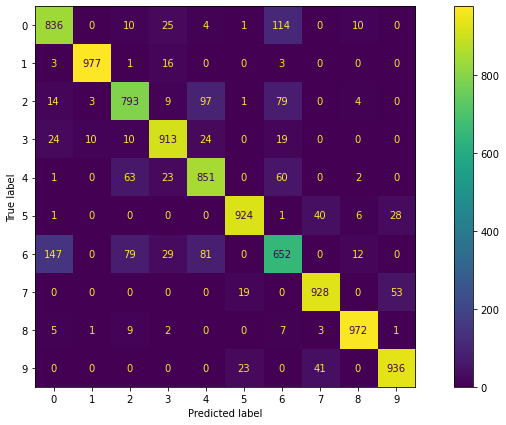

In [32]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(14,7)
plot_confusion_matrix(stacking_clf,original_X_test_scaled,y_test,ax=ax)

In [33]:
voting_clf = load_model('voting_clf')

if not voting_clf:
    voting_clf = VotingClassifier(
        estimators=[('knn',tuned_knn),
                    ('rf',tuned_forest),
                    ('xgb',tuned_xgb)],
                voting='soft',
                weights=[1,1,4],
    )

    voting_clf.fit(x_train_scaled,y_train_data)
    save_model(voting_clf,"voting_clf")
else:
    print("loaded pre trained model")

loaded pre trained model


In [34]:
voting_clf.score(original_X_test_scaled,y_test)

0.8936